In [1]:
import h5py, os, pystan
import numpy as np
from os.path import dirname
from pandas import DataFrame, read_csv, concat
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

In [2]:
import os, pystan
import _pickle as pickle
from pandas import DataFrame

def load_model(filepath):
    """Load or precomplile a StanModel object.
    Parameters
    ----------
    filepath : str
        Path to the Stan model.
    Returns
    -------
    StanModel : pystan.StanModel
        Model described in Stan’s modeling language compiled from C++ code.
    Notes
    -----
    If an extensionless filepath is supplied, looks for *.stan or *.txt files for StanCode 
    and *.pkl and *.pickle for StanModels. Otherwise requires a file with one of those four extensions.
    """

    for ext in ['.pkl','.pickle','.stan','.txt']:

        if filepath.endswith(ext):
            break
        elif os.path.isfile(filepath + ext):
            filepath += ext
            break

    if filepath.lower().endswith(('.pkl','.pickle')):

        ## Load pickle object.
        StanModel = pickle.load(open(filepath, 'rb'))

    elif filepath.lower().endswith(('.stan','.txt')):

        ## Precompile StanModel.
        StanModel = pystan.StanModel(file=filepath)

        ## Dump to pickle object.
        f = '.'.join(filepath.split('.')[:-1]) + '.pkl'
        with open(f, 'wb') as f: pickle.dump(StanModel, f)

    else:

        raise IOError('%s not correct filetype.' %filepath)

    return StanModel

In [3]:
PATH_NAME = '/Users/kierstenmarr/Desktop/EA'

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
stan_model = 'EA.stan'

## Sampling parameters.
samples = 4000
warmup = 2000
chains = 4
thin = 1
n_jobs = 4

## Seed.
seed = 0

In [5]:
from numba import njit

@njit
def inv_logit(arr):
    """Fast inverse logistic function."""
    return 1. / (1. + np.exp(-arr))

In [14]:
class EA(object):
    
    def __init__(self, b1, b2, eta1, eta2, w, p):
        
        ## Define parameters.
        self.b1 = b1
        self.b2 = b2
        self.eta1 = eta1
        self.eta2 = eta2
        self.w = w
        self.p = p
        
        ## Initialize Q-values.
        self.Qs1 = None
        self.Qs2 = None
        
    def train(self, drifts, reset=False):
        
        ## Error-catching: rewards.
        ##drifts = np.array(drifts)
        
        ## Initialize Q-values.
        if self.Qs1 is None or reset:
            self.Qs1 = 0.5 * np.ones(2)
        
        if self.Qs2 is None or reset:
            self.Qs2 = 0.5 * np.ones((2,2))
            
        ## Preallocate space.
        n_trials = drifts.shape[0]    
        Y1, Y2, S2, t, r = np.zeros((5,n_trials), dtype=int)
            
        for i in range(n_trials):

            theta1 = inv_logit( self.b1 * (self.Qs1[1] - self.Qs1[0]))
            
            ## Stage 1: Simulate choice.
            Y1[i] = np.random.binomial(1,theta1)
            
            ## Simulate transition.
            t[i] = np.random.binomial(1, 0.7)
            S2[i] = np.where(t[i], Y1[i], 1-Y1[i])
                        
            ## Stage 2: Compute choice likelihood.
            theta2 = inv_logit( self.b2 * (self.Qs2[S2[i],1] - self.Qs2[S2[i],0]) )
            
            ## Stage 2: Simulate choice.
            Y2[i] = np.random.binomial(1,theta2)
            
            ## Stage 2: Observe outcome.
            #r[i] = R[i,S-1,Y[i,1]]
            r[i] = np.random.binomial(1, drifts[i, S2[i], Y2[i]])
            
            ## Update stage 2 Q-values
            self.Qs2[S2[i], Y2[i]] += self.eta2 * (r[i] - self.Qs2[S2[i], Y2[i]])
            # where's eta1 in all this?
            
            if t[i]: cr = 0.7  # common transition
            else: cr = 0.3     # rare transition
            
            ## Update Stage 1 Q-values
            # Chosen action
            deltaC = r[i] - self.Qs1[Y1[i]]
            self.Qs1[Y1[i]] += self.eta1 * (self.w * cr * deltaC + (1 - self.w) * deltaC)
            
            # Unchosen action
            deltaU = r[i] - self.Qs1[1 - Y1[i]]
            self.Qs1[1-Y1[i]] += self.eta1 * self.w * (1-cr) * deltaU
            
        return Y1, Y2, S2, t, r

In [15]:
from tqdm import tqdm

In [16]:
import seaborn as sns
sns.set('notebook', style='white', font='sans-serif', font_scale=1.33)

100%|██████████| 201/201 [00:01<00:00, 124.96it/s]


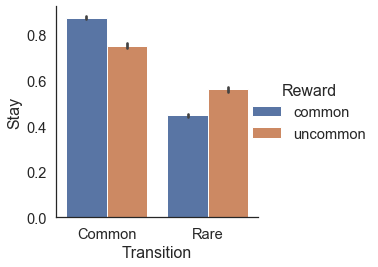

In [17]:
np.random.seed(47404)

## Define reward parameters.
drifts = read_csv('drifts.txt', header=None).values.reshape(-1,2,2)
T = drifts.shape[0]

data = []
for _ in tqdm(range(T)):
    
    ## Simulate outcomes.
    ##R = np.random.binomial(1, [[0.5,0.5],[0.5,0.5]], (200,2,2))
    
    ## Initialize agent.
    agent = EA(b1 = 7.0, b2 = 7.0, eta1 = 0.5, eta2 = 0.5, w = 0.5, p = 0.2)

    ## Train agent.
    Y1, Y2, S2, t, r = agent.train(drifts)
    
    ## Define variables.
    prev_R = np.roll(r, 1)[1:]
    prev_T = np.roll(t, 1)[1:]
    stay = Y1[:-1] == Y1[1:]
    
    ## Blah.
    df = DataFrame(np.column_stack([prev_R, prev_T, stay]), columns=['prev_R', 'prev_T', 'Stay'])
    data.append(df)
    
## Concatenate DataFrames.
data = concat(data)
data.prev_R = data.prev_R.replace({1:'rewarded',0:'unrewarded'})
data.prev_T = data.prev_T.replace({1:'common',0:'uncommon'})

ax = sns.barplot('prev_R', 'Stay', 'prev_T', data=data, order=['rewarded','unrewarded'], 
                 hue_order=['common','uncommon'])

ax.set(xticklabels=['Common','Rare'], xlabel='Transition', ylabel='Stay')
ax.legend(loc=10, bbox_to_anchor=(1.25,0.5), frameon=False, title='Reward')

sns.despine()
plt.tight_layout()

In [18]:
# NOTE: haven't run whole block yet!
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit Stan Model.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Assemble data.
dd = dict(T=T, Y1=Y1, Y2=Y2, O=S2, reward=r)
   
## Load StanModel
StanModel = load_model(PATH_NAME)

# .optimize -- MAP estimation

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bffbd421009e6eded8ba0311899b7864 NOW.


In [19]:
StanModel.optimizing(data=dd)

OrderedDict([('eta1_pr', array(-2.24641309)),
             ('eta2_pr', array(-1.83046299)),
             ('beta1_pr', array(-0.74586459)),
             ('beta2_pr', array(-2.05972584)),
             ('w_pr', array(-0.0255439)),
             ('p_pr', array(-0.00045137)),
             ('eta1', array(0.01226391)),
             ('eta2', array(0.03366337)),
             ('beta1', array(4.55566389)),
             ('beta2', array(0.39401766)),
             ('w', array(0.48979889)),
             ('p', array(0.49981972)),
             ('Y1_pd', array(0.498847)),
             ('Y2_pd', array(0.49797388))])

In [20]:
## Fit model.
StanFit = StanModel.sampling(data=dd, iter=samples, warmup=warmup, chains=chains, thin=thin, n_jobs=n_jobs, seed=44404)

In [21]:
print(StanFit)

Inference for Stan model: anon_model_bffbd421009e6eded8ba0311899b7864.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
eta1_pr   -1.61    0.02    1.2  -3.25  -2.47  -1.96  -0.88   1.21   2796    1.0
eta2_pr   -1.51    0.02    1.4  -3.56  -2.67  -1.74  -0.48   1.39   3187    1.0
beta1_pr  -1.37    0.02   1.24  -3.29  -2.36  -1.54  -0.49   1.29   3004    1.0
beta2_pr  -1.95    0.02   1.19   -3.6  -2.82  -2.28  -1.22   0.89   3040    1.0
w_pr       0.16    0.01   1.01  -1.82  -0.51   0.17   0.83   2.08   5777    1.0
p_pr       0.02    0.01   1.02  -1.97  -0.66   0.01   0.71   1.99   5948    1.0
eta1       0.16  4.6e-3   0.25 4.9e-4 6.6e-3   0.02   0.19   0.89   2965    1.0
eta2        0.2  4.6e-3   0.28 1.4e-4 3.7e-3   0.04   0.31   0.92   3600    1.0
beta1      3.97    0.09   5.24 8.3e-3   0.18   1.24   6.22  18.04   3435    1.0
beta2      